<a href="https://colab.research.google.com/github/Joshna9380/OIBSIP/blob/main/customer_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [14]:
data = pd.read_csv("data.csv", encoding='unicode_escape')
print("Shape:", data.shape)
data.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
# Drop missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Remove canceled/negative transactions
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


In [16]:

snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)


rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'Quantity': 'TotalQuantity',
                    'UnitPrice': 'AvgPrice'}, inplace=True)


data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
monetary = data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
rfm = rfm.merge(monetary, on='CustomerID')
rfm.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,TotalQuantity,AvgPrice,Monetary
0,12346.0,326,1,74215,1.040000,77183.60
1,12347.0,2,7,2458,2.644011,4310.00
2,12348.0,75,4,2341,5.764839,1797.24
3,12349.0,19,1,631,8.289041,1757.55
4,12350.0,310,1,197,3.841176,334.40


In [17]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


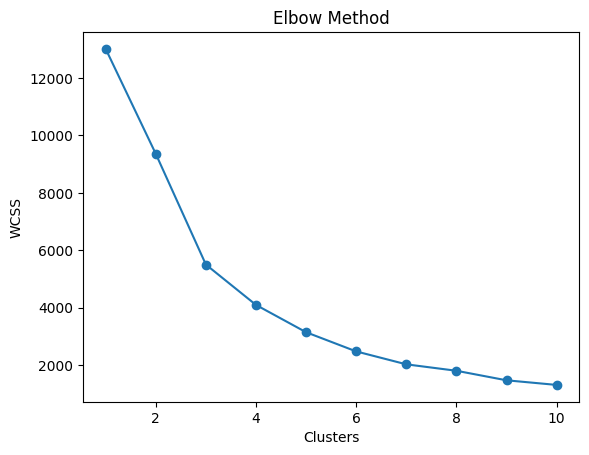

In [18]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("WCSS")
plt.show()


In [19]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)


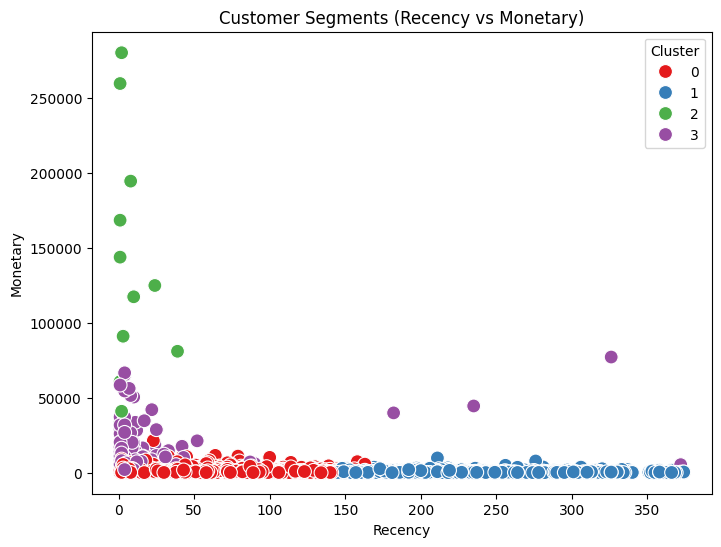

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm['Recency'], y=rfm['Monetary'],
                hue=rfm['Cluster'], palette="Set1", s=100)
plt.title("Customer Segments (Recency vs Monetary)")
plt.show()

In [21]:
cluster_summary = rfm.groupby('Cluster').mean()[['Recency','Frequency','Monetary']]
print(cluster_summary)


            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1359.049284
1        248.075914   1.552015     480.617480
2          7.384615  82.538462  127338.313846
3         15.500000  22.333333   12709.090490
